# IIE4123 HW3
## Kichang Lee(2019193016), School of Integrated Technology, Yonsei Univ

Language : Python3(Python 3.9.7 64-bit)

OS : Microsoft Windows 10 Education (10.0.19042)

Environment

CPU : Intel(R) Core(TM) i9-10850K CPU 3.60GHz, 3600Mhz, 10 Core with Intel(R) UHD Graphics 630

RAM : 64GB

GPU : RTX3090

## Notes about Task2

Task2 : (Transfer Learning and Fine Tuning) Open Transfer Learning ipynb. you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

(a) please list techiques that have been used in the code

- Data augmentations are used. Random horizontal flip and random rotation is applied.
- Convolutional base freezing is applied.
- Batch normalization is applied.
- input pixel value rescaling is applied.


(b) Please check test accuracies from the feature extractor model and fine-tuning model

-> as feature extractor model
   loss: 0.1865 - accuracy: 0.9120 - val_loss: 0.1003 - val_accuracy: 0.9703
   as fine-tuning model
   loss: 0.0544 - accuracy: 0.9795 - val_loss: 0.0319 - val_accuracy: 0.9827
   
   the one with fine tuning model showed better performance.


(c) Check if you increase the learning rate in the fine-tuning (current setting = base_learning_rate/10) what will happen. You can show with test accuracies or validation accuracies

-> with lr=base_learning_rate
   loss: 0.0624 - accuracy: 0.9765 - val_loss: 0.0689 - val_accuracy: 0.9802
   you can check the training result in the final cell that shows the loss and accuracy graph. It didn't show proper learning progress. The based model is already learned in feature extraction and what we have to do is 'fine' tuning. the one with smaller learning rate is apt choice for transfer learning situation.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


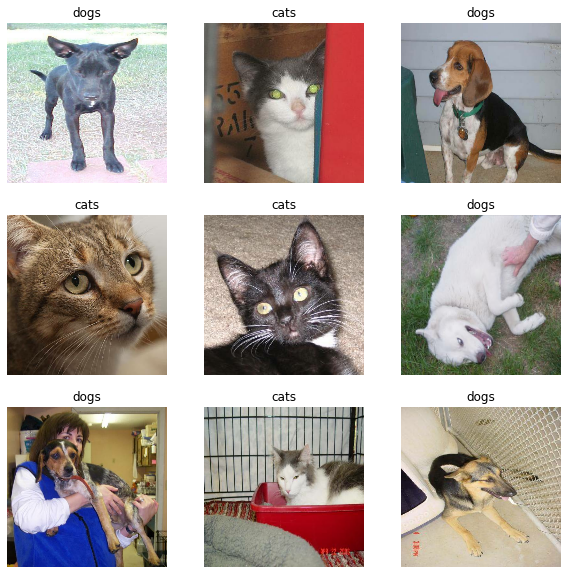

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

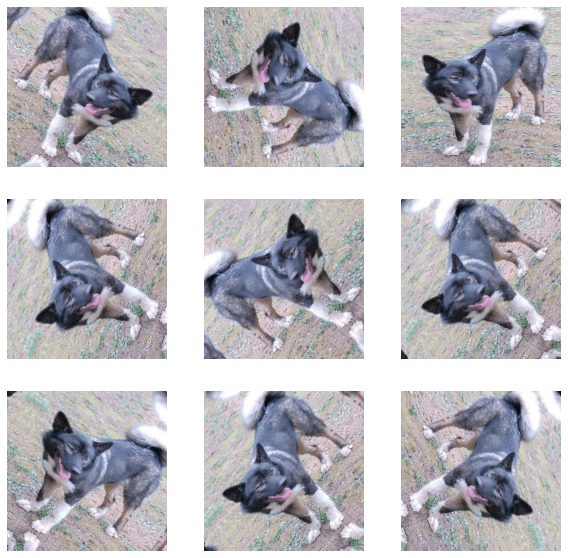

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
base_model.trainable = False

In [12]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
len(model.trainable_variables)

2

### Training

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 15s 500ms/step - loss: 0.7862 - accuracy: 0.4802


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.48


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 52s 769ms/step - loss: 0.7285 - accuracy: 0.5550 - val_loss: 0.5471 - val_accuracy: 0.6869
Epoch 2/10
63/63 [==============================] - 49s 779ms/step - loss: 0.5342 - accuracy: 0.7135 - val_loss: 0.3876 - val_accuracy: 0.8069
Epoch 3/10
63/63 [==============================] - 53s 838ms/step - loss: 0.4300 - accuracy: 0.7805 - val_loss: 0.3017 - val_accuracy: 0.8663
Epoch 4/10
63/63 [==============================] - 53s 836ms/step - loss: 0.3500 - accuracy: 0.8375 - val_loss: 0.2384 - val_accuracy: 0.9134
Epoch 5/10
63/63 [==============================] - 49s 778ms/step - loss: 0.3248 - accuracy: 0.8495 - val_loss: 0.2029 - val_accuracy: 0.9369
Epoch 6/10
63/63 [==============================] - 49s 782ms/step - loss: 0.2845 - accuracy: 0.8755 - val_loss: 0.1793 - val_accuracy: 0.9480
Epoch 7/10
63/63 [==============================] - 49s 772ms/step - loss: 0.2495 - accuracy: 0.8940 - val_loss: 0.1553 - val_accuracy: 0.9554

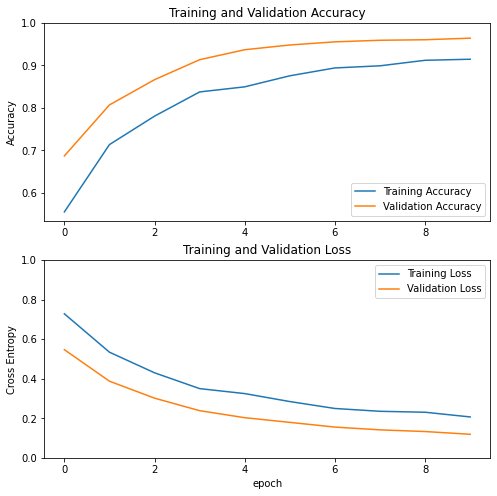

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-Tuning

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
len(model.trainable_variables) 

56

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 82s 1s/step - loss: 0.1527 - accuracy: 0.9355 - val_loss: 0.0526 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 75s 1s/step - loss: 0.1146 - accuracy: 0.9540 - val_loss: 0.0417 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 75s 1s/step - loss: 0.1058 - accuracy: 0.9555 - val_loss: 0.0413 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 73s 1s/step - loss: 0.0921 - accuracy: 0.9635 - val_loss: 0.0417 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 74s 1s/step - loss: 0.0953 - accuracy: 0.9615 - val_loss: 0.0405 - val_accuracy: 0.9901
Epoch 15/20
63/63 [==============================] - 74s 1s/step - loss: 0.0817 - accuracy: 0.9690 - val_loss: 0.0373 - val_accuracy: 0.9802
Epoch 16/20
63/63 [==============================] - 73s 1s/step - loss: 0.0838 - accuracy: 0.9670 - val_loss: 0.0311 - val_accuracy: 0.9864
Epoch 17/20
6

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

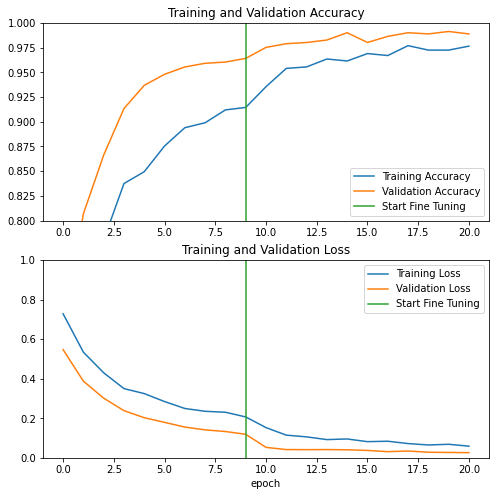

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 487ms/step - loss: 0.0205 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


Predictions:
 [0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0]
Labels:
 [0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0]


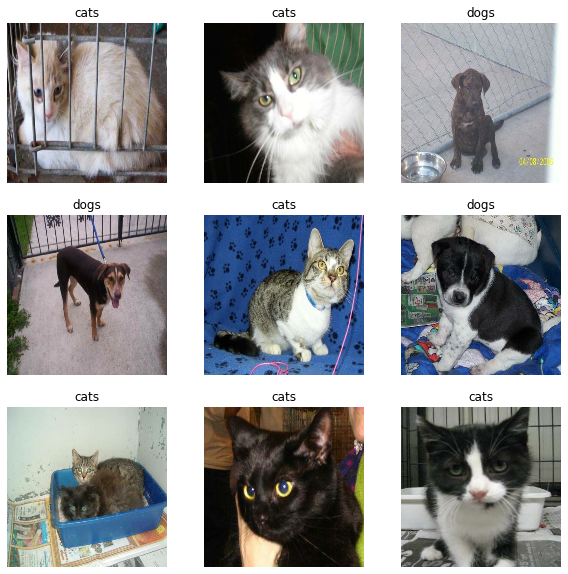

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

3. Increase the learning rate

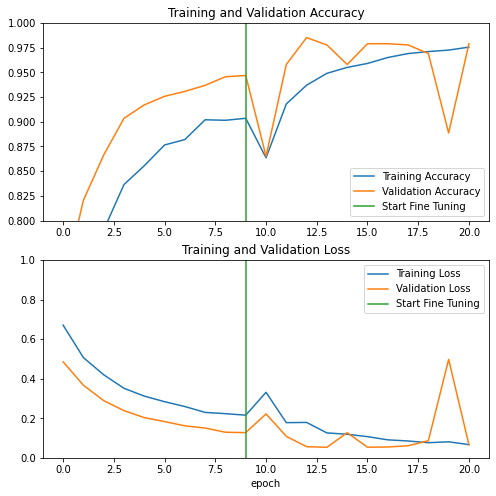

In [4]:
from IPython.display import Image

#result of increased learning rate. lr=base_learning_rate
Image("./3.png")
